# Simulation of interacting species
The following code simulates the abundaces of different interacting species over time. It uses a defined initial conmosition and a payoff matrix to calculate the abundances of the species at each time step. This simulation uses stocastic predictions as described in the [Gillespie algorithm](https://lewiscoleblog.com/gillespie-algorithm) and presents the results in a plot. 

In [23]:
# Simulation of n species with interactions
# Import packages
import numpy as np
import random


# Set initial conditions
time_steps = 70000
replications = 5
carrying_capacity = 5000
initial_population = 100
number_of_species = 8
time_max = 30
time_step_max = 1

np.random.seed(2)

# create empty arrays for simulation results
time_for_change = np.zeros((replications, time_steps+1))
composition_over_time = np.zeros((replications, time_steps+1, number_of_species))

time_for_change[:, 1:] = np.nan
composition_over_time[:] = np.nan

# Define the initial number of individuals of each species
# automated version
# create random array that sums to initial_population
initial_composition = np.zeros(number_of_species)
for i in range(number_of_species-1):
    #max = sum(initial_composition)
    initial_composition[i] = np.random.randint(0, high=(initial_population - sum(initial_composition)), size=1, dtype=int)
initial_composition[-1] = initial_population - sum(initial_composition)
#print("initial_composition = ", initial_composition)

# Define species-specific reproduction, death rates
birth_death = np.zeros((number_of_species, 2))
for i in range(number_of_species):
    birth_death[i, 0] = 1
    birth_death[i, 1] = 0.1

# Define payoff matrix
# automated version
payoff_matrix = np.random.rand(number_of_species, number_of_species)
#print("payoff_matrix = ", payoff_matrix)

# Define pertibation affinity
pertubation = np.zeros(number_of_species)
# pertubation = np.asarray([0.99, 0.1, 0.5, 0.99])
# Define when pertubation is active
pertubation_graph = np.zeros(time_steps)
pertubation_length = 2000
for i in range(pertubation_length):
    t = i + int(time_steps-2000)
    pertubation_graph[t] = 1


In [24]:
print("initial_composition = ", initial_composition)
print("payoff_matrix = ", "\n", payoff_matrix)
print("birth_death = ", "\n", birth_death)

initial_composition =  [40. 15.  8. 22. 11.  2.  1.  1.]
payoff_matrix =  
 [[0.4203678  0.33033482 0.20464863 0.61927097 0.29965467 0.26682728
  0.62113383 0.52914209]
 [0.13457995 0.51357812 0.18443987 0.78533515 0.85397529 0.49423684
  0.84656149 0.07964548]
 [0.50524609 0.0652865  0.42812233 0.09653092 0.12715997 0.59674531
  0.226012   0.10694568]
 [0.22030621 0.34982629 0.46778748 0.20174323 0.64040673 0.48306984
  0.50523672 0.38689265]
 [0.79363745 0.58000418 0.1622986  0.70075235 0.96455108 0.50000836
  0.88952006 0.34161365]
 [0.56714413 0.42754596 0.43674726 0.77655918 0.53560417 0.95374223
  0.54420816 0.08209492]
 [0.3663424  0.8508505  0.40627504 0.02720237 0.24717724 0.06714437
  0.99385201 0.97058031]
 [0.80025835 0.60181712 0.76495986 0.16922545 0.29302323 0.52406688
  0.35662428 0.04567897]]
birth_death =  
 [[1.  0.1]
 [1.  0.1]
 [1.  0.1]
 [1.  0.1]
 [1.  0.1]
 [1.  0.1]
 [1.  0.1]
 [1.  0.1]]


## Equations for simulation
MathJax is used to display the equations in this notebook.

$N$ = number of all individuals

$K$ = carrying capacity

$n_i$ = abundance of species $i$

$death_i$ = death rate of species $i$

$a_{ij}$ = payoff between species $i$ and $j$

$b_i$ = birth rate of species $i$

$p_i$ = effect of antibiotic/pertubation on species $i$

$p_t$ = intensity of pertubation


Individual fitness: (includes all factors that determine how fast a species can reproduce)
\begin{equation}
f_i = \frac{K - N}{K}  b_i n_i \sum_{j=1}^s a_{ij} n_j
\end{equation}

\begin{equation}
f_i = \frac{K - N}{K}  b_i n_i \frac {\sum_{j=1}^s a_{ij} n_j}{\sum_{i=1}^s{\sum_{j=1}^s a_{ij} n_j}}
\end{equation}

Sum of fitness(Average):
\begin{equation}
F = \sum_{i=1}^s f_i
\end{equation}

Individual death: ## Here i can add influence of antibiotics
\begin{equation}
d_i = n_i (death_i + p_i p_t)
\end{equation}

Sum of death (Average) :
\begin{equation}
D = \sum_{i=1}^s d_i
\end{equation}

Reproduction propability:
\begin{equation}
T^{n_i \to n_i+1} = \frac{f_i}{F + D}
\end{equation}

Death propability:
\begin{equation}
T^{n_i \to n_i-1} = \frac{d_i}{F + D}
\end{equation}

## Parallelization TEST
The indipendent replications of the simulation are run in parallel. This can be done with [DASK](https://www.dask.org/). The following code is used to set up the parallelization.

import dask

@dask.delayed
def inc(x):
   return x + 1

@dask.delayed
def add(x, y):
   return x + y

a = inc(1)       # no work has happened yet
b = inc(2)       # no work has happened yet
c = add(a, b)    # no work has happened yet

c = c.compute()  # This triggers all of the above computations

In [25]:

# for r in range(replications):
#     # set initial conditions
#     composition_over_time[r, 0, :] = initial_composition

last_step = np.zeros(replications)

# Run simulation
for r in range(replications):
    # set initial conditions
    composition_over_time[r, 0, :] = initial_composition
    current_time = 0
    t = 0
    time = 0
    #while time < time_step_max and t < time_steps:
    while current_time < time_max and t < time_steps:
    #for t in range(time_steps):
        #if current_time < time_max:
        #if time < time_step_max:
        individual_fitness = np.zeros(number_of_species)
        individual_death = np.zeros(number_of_species)
        average_fitness = 0
        average_death = 0
        for i in range(number_of_species):
            for j in range(number_of_species):
                individual_fitness[i] += composition_over_time[r, t, j]*payoff_matrix[i, j]
        individual_fitness = individual_fitness / sum(individual_fitness)
        for i in range(number_of_species):
            # for j in range(number_of_species):
            #     individual_fitness[i] += composition_over_time[r, t, j]*payoff_matrix[i, j]
            individual_fitness[i] = individual_fitness[i]*composition_over_time[r, t, i]*((carrying_capacity - sum(composition_over_time[r, t, :]))/carrying_capacity)*birth_death[i,0]
            individual_death[i] = composition_over_time[r, t, i]*(birth_death[i, 1]+pertubation[i]*pertubation_graph[t])
        average_fitness = sum(individual_fitness)
        average_death = sum(individual_death)

          # calculate time for next change
        change_probability = average_fitness + average_death
        random_number = np.random.random()
        time = 1/change_probability * np.log(1/random_number)
        time_for_change[r, t+1] = time_for_change[r, t] + time
        current_time = time_for_change[r, t] + time

        # calculate the probability of each species to reproduce or die
        reproduction_probability = np.zeros(number_of_species)
        death_probability = np.zeros(number_of_species)
        for j in range(number_of_species):
            reproduction_probability[j] = (individual_fitness[j])/(average_fitness + average_death)
            death_probability[j] = individual_death[j]/(average_fitness + average_death)
        #print("reproduction_probability", reproduction_probability)

      
        all_probabilities = np.concatenate((reproduction_probability, death_probability))
        choose = np.random.choice(all_probabilities.size, 1, p=all_probabilities) # gives index of chosen species if p not =1 (/sum(all_probabilities)
        # set the new composition
        composition_over_time[r, t+1, :] = composition_over_time[r, t, :]
        if choose < number_of_species:
            #composition[choose] += 1
            composition_over_time[r, t+1, choose] += 1
        else:
            #composition[choose - number_of_species] -= 1
            composition_over_time[r, t+1, (choose - number_of_species)] -= 1
        t += 1
        # save the new composition
        #composition_over_time[r, t+1, :] = composition
    composition_over_time[r, t, :] = composition_over_time[r, t-1, :]
    last_step[r] = t
    last_time = np.nanmax(time_for_change)

r = 0
for k in last_step:
    time_for_change[r, int(k)] = np.nanmax(time_for_change)
    r += 1


    



In [26]:
print(individual_fitness)
print(individual_death)

[4.14901032e+00 8.76018341e+00 4.40070058e-02 3.20079574e+00
 6.57612656e+01 3.93916214e+00 0.00000000e+00 0.00000000e+00]
[ 5.4  5.3  0.1  2.6 32.9  3.   0.   0. ]


In [27]:

print("last_step = ", last_step)
r = 0

for k in last_step:
    print(time_for_change[r, int(k)])
    print(composition_over_time[r, int(k), :])
    time_for_change[r, int(k)] = np.nanmax(time_for_change)
    r += 1

last_step =  [1119.  868. 1319. 1207. 1704.]
30.01666938304288
[ 53.  80.   2.  23. 110.   2.   0.   8.]
30.01666938304288
[ 14.  19.   3.  10. 188.  13.   0.   0.]
30.01666938304288
[ 34.  84.   1.  17. 209.  11.   0.   0.]
30.01666938304288
[ 57. 100.   1.  13. 179.   0.   0.   0.]
30.01666938304288
[ 54.  53.   1.  26. 329.  30.   0.   0.]


In [28]:
print("time_for_change", time_for_change)
print("composition_over_time", composition_over_time)
print(np.nanmax(composition_over_time))
print("time for change max", np.nanmax(time_for_change))
print(time_for_change.size/replications)
print(last_time)

np.savetxt("time_for_change.csv", time_for_change, delimiter=",")


# x = np.argmax(time_for_change)
# print(x)
# print(time_for_change[0, x-1])
# print(time_for_change[0, x])
# print(time_for_change[0, x] - time_for_change[0, x-1])

# print(time_for_change.max()*0.03)
# for r in range(1):
#     for i in range(time_steps):
#         if time_for_change.max()*0.03 <= time_for_change[r, i] and time_for_change[r, i] <= time_for_change.max()*0.03 + 0.0001:
#             print(time_for_change[0, i])
#             print(i)
#             print(time_for_change[0, i+1])


time_for_change [[0.         0.00079654 0.03247018 ...        nan        nan        nan]
 [0.         0.01267152 0.01538429 ...        nan        nan        nan]
 [0.         0.02417944 0.07903494 ...        nan        nan        nan]
 [0.         0.02415172 0.05233599 ...        nan        nan        nan]
 [0.         0.04280035 0.0574824  ...        nan        nan        nan]]
composition_over_time [[[40. 15.  8. ...  2.  1.  1.]
  [40. 15.  8. ...  2.  1.  1.]
  [40. 15.  8. ...  2.  1.  1.]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 [[40. 15.  8. ...  2.  1.  1.]
  [39. 15.  8. ...  2.  1.  1.]
  [38. 15.  8. ...  2.  1.  1.]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 [[40. 15.  8. ...  2.  1.  1.]
  [40. 14.  8. ...  2.  1.  1.]
  [40. 14.  8. ...  2.  1.  1.]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan

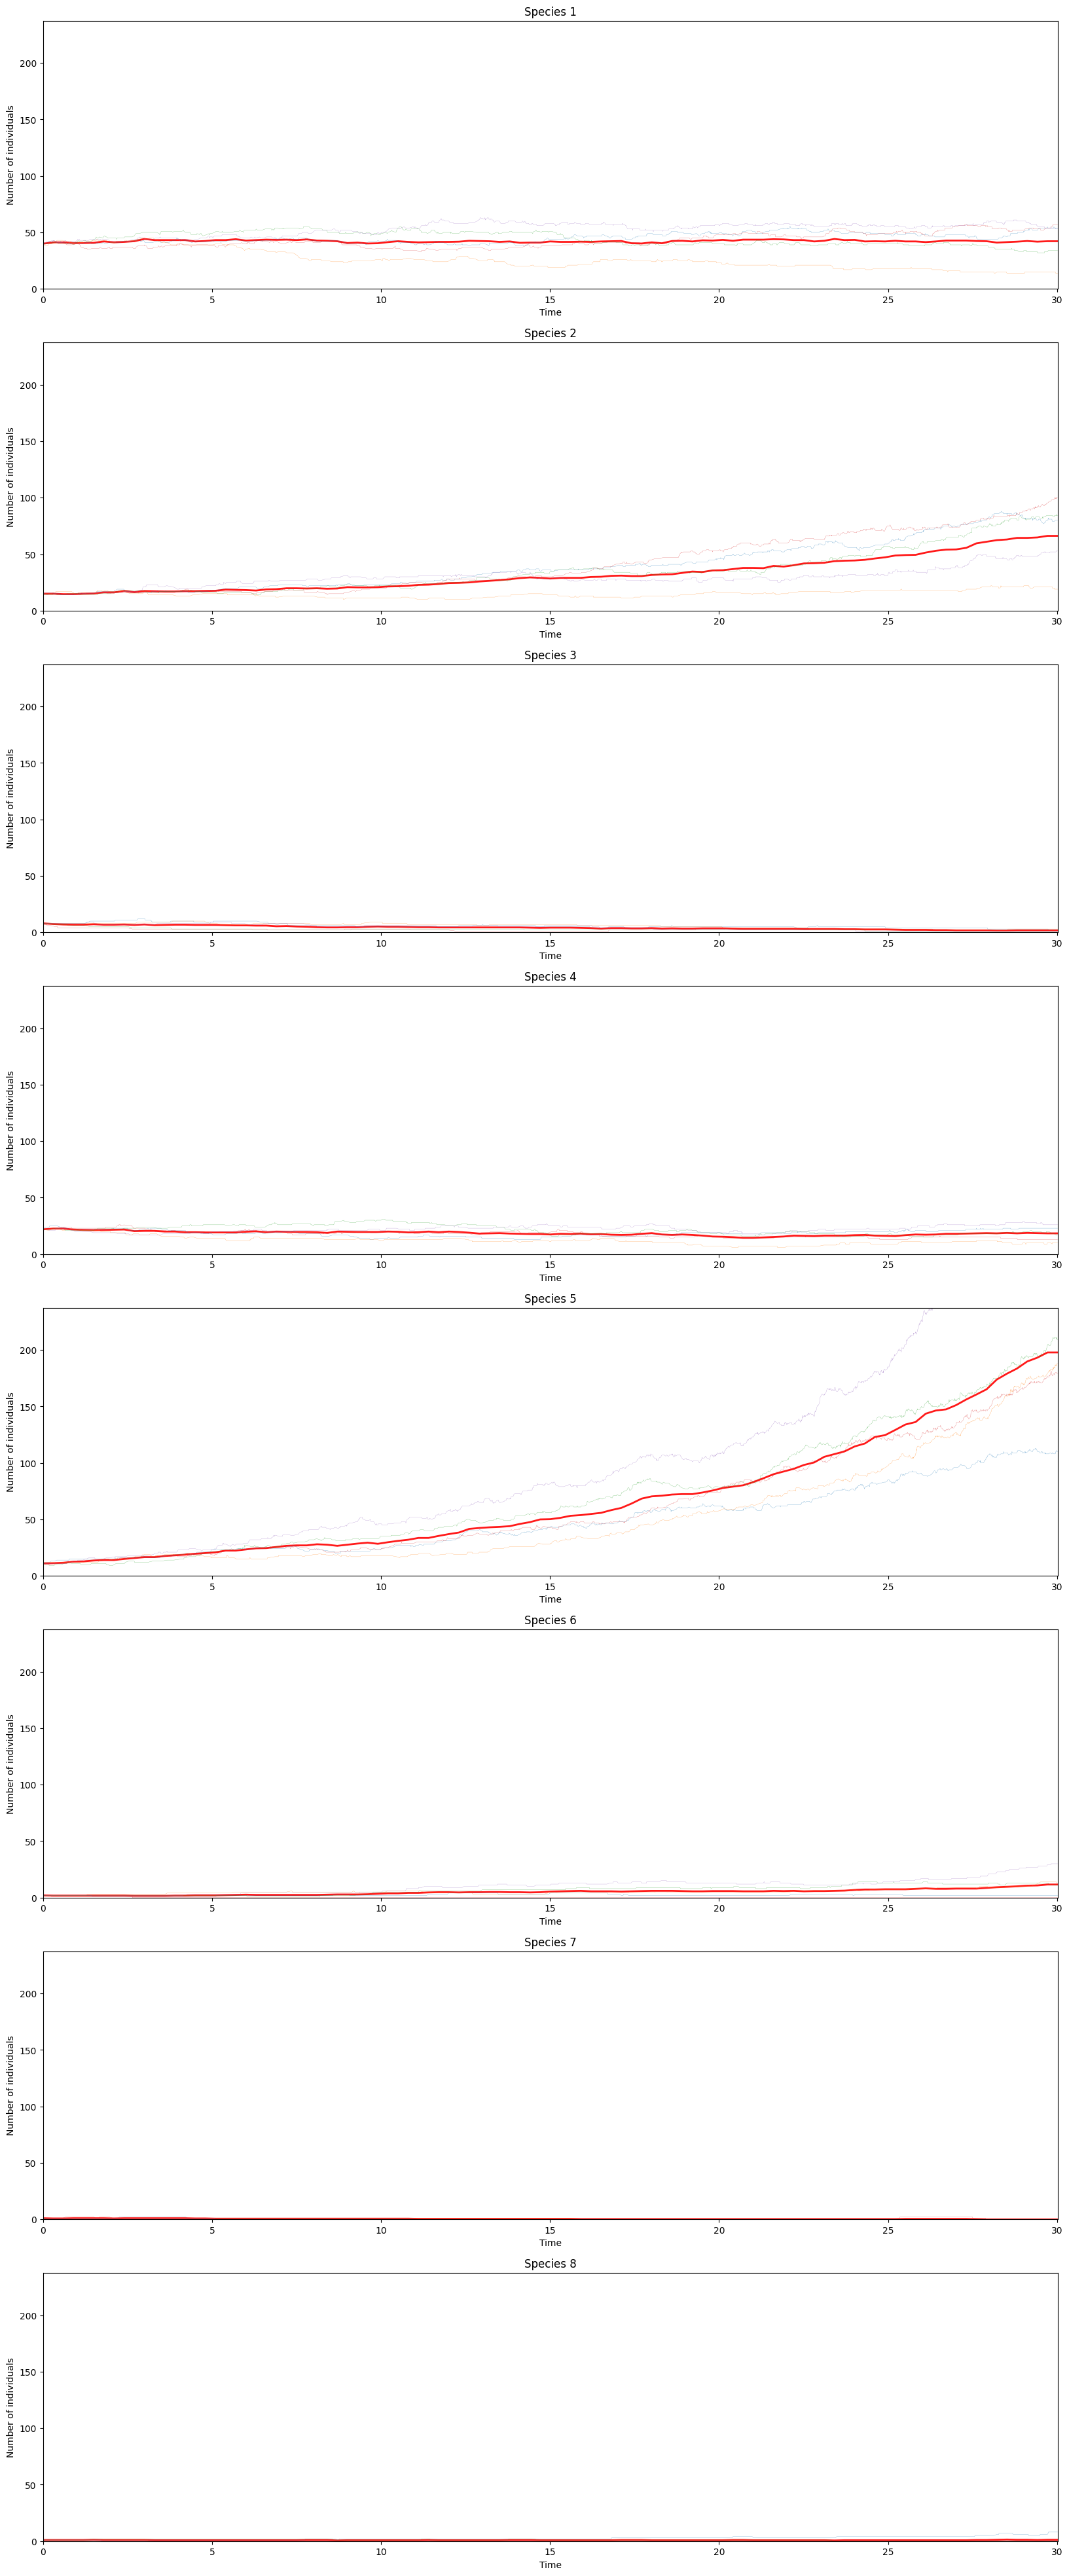

In [29]:

#print(composition_over_time)

# Visualize the results
import matplotlib.pyplot as plt


# Prepare average arrays
max_time_for_change = np.nanmax(time_for_change) # highest time after all steps
average_time_steps = 100 # number of time steps for the average arrays
average_time_for_change = np.linspace(0, max_time_for_change, average_time_steps+1) # create array with conistent time steps from 0 to max_time_for_change

average_composition = np.zeros((number_of_species, average_time_steps+1)) # create a matrix with zeros for the average composition
#average_composition[average_composition == 0] = np.nan # replace all zeros with NaNs
average_composition[:, 0] = initial_composition # insert the initial composition

# Calculate average arrays
# check for average changes in each time interval
for t in range(1, average_time_for_change.size):
    max_time = average_time_for_change[t] # highest time for this time interval
    composition_sum = np.zeros(number_of_species) # create empy array for the sum of the changes in that time interval
    count_changes = 0 # count the number of changes in that time interval

    # sum up the composition changes in that time interval
    for r in range(replications):
        for i in range(time_steps):
            if time_for_change[r, i] <= max_time and time_for_change[r, i+1] > max_time:
                composition_sum += composition_over_time[r, i, :]
                count_changes += 1

    # calculate the average composition in that time interval (divide by the count of changes)
    if count_changes == 0:
        average_composition[:, t] = average_composition[:, t-1] # if there was no change in that time interval, the composition stays the same
    else:
        average_composition[:, t] = composition_sum/count_changes # if there was a change in that time interval, calculate the average composition

# Plot the results
fig, axs = plt.subplots(number_of_species, 1, figsize=(20, 50)) #create a figure with subplots for each species
# set axes, data, labels and limits (for average compositions)
for i in range(number_of_species):
    axs[i].plot(average_time_for_change, average_composition[i, :], color='red', linewidth=2, alpha=0.9)
    axs[i].set_title('Species ' + str(i+1))
    axs[i].set_xlabel('Time')
    axs[i].set_ylabel('Number of individuals')
    axs[i].set_xlim(0, max_time_for_change)
    axs[i].set_ylim(0, average_composition.max()*1.2)
# include individual compositions of the replications

#time_for_change[time_for_change == 0] = np.nan
#composition_over_time[composition_over_time == 0] = np.nan

for r in range(replications):
    for i in range(number_of_species):
        axs[i].plot(time_for_change[r, :], composition_over_time[r, :, i], linewidth=0.2, alpha=0.8)


#plt.show()


In [30]:
print("average_composition", average_composition)

average_composition [[ 40.   41.2  41.2  40.6  40.6  40.8  42.   41.2  41.6  42.2  44.2  43.2
   43.2  43.2  43.2  42.   42.4  43.2  43.2  44.   42.8  43.2  43.6  43.4
   43.6  43.2  43.8  42.8  42.6  42.2  40.6  41.   40.2  40.4  41.4  42.2
   41.6  41.2  41.4  41.6  41.6  41.8  42.6  42.4  42.2  41.6  42.   40.8
   41.   41.   42.   41.6  41.6  41.8  41.6  42.   42.2  42.4  40.4  40.2
   41.2  40.4  42.4  42.6  42.   43.   42.8  43.4  42.6  43.6  43.6  43.6
   44.   43.8  43.2  43.2  42.   42.6  44.2  43.2  43.4  42.   42.2  42.
   42.6  42.   42.   41.4  42.   42.8  42.8  42.8  42.4  42.2  41.   41.4
   41.8  42.4  41.8  42.2  42.2]
 [ 15.   15.   14.6  14.6  15.   15.2  16.2  16.2  17.4  16.4  17.4  17.2
   17.   17.   17.2  17.2  17.4  17.6  18.6  18.4  18.2  17.8  18.8  19.
   19.8  19.8  19.6  19.8  19.4  19.6  20.8  20.6  20.6  20.8  21.4  21.6
   22.   22.8  23.   23.6  24.4  24.6  25.   25.8  26.4  27.   27.8  28.8
   29.4  29.   28.4  29.   29.   29.   29.8  30.   30.8  31. 